## Imports

In [2]:
import copy
import glob
import importlib
import itertools
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import SimpleITK as sitk
import skimage.feature as skf
from skimage.morphology import ball

import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config

%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [362]:
importlib.reload(config)
C = config.Config()
target_dir = "D:\\Lipiodol\\Data"

## Pattern analysis

In [416]:
patients = [basename(fn) for fn in glob.glob(join(target_dir,"*"))]
num_patients = len(patients)

In [315]:
patient_id = "PK-08"
importlib.reload(lm)
paths = lm.get_paths(patient_id, target_dir, check_valid=False)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

### Validate HU scale

In [357]:
LI = []
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    img,D = hf.nii_load(ct24_path)
    M = masks.get_mask(ct24_tumor_mask_path, D, img.shape)[0]
    img = img*M/M.max()
    
    LI.append(filters.threshold_li(img[img > 100]))

In [342]:
np.percentile(LI, 100/3), np.percentile(LI, 200/3)

(159.8438546709155, 215.4651656444234)

### Build DataFrame

In [405]:
pattern_feat_cols = ["enhancing_vol%", "lipcoverage_vol%",
                       "rim_enhancing%", "rim_lipiodol%",
                       "peripheral_coverage%"]

lipresp_cols = []
for name in itertools.product(["base_", "low_", "mid_", "high_"], ["resp%", "prog%", "bl_enh%", "30d_enh%"]):
    lipresp_cols.append(name[0]+name[1])
    
# resp% is the % of BL enhancing tumor that becomes necrotic within this lipiodol range
# prog% is the % of BL necrotic tumor that becomes enhancing within this lipiodol range
# bl_enh% is the % of tumor within this lipiodol range that is enhancing on BL MR
# 30d_enh% is the % of tumor within this lipiodol range that is enhancing on 30d MR

In [406]:
pattern_df = pd.DataFrame(columns=pattern_feat_cols)
lipresp_df = pd.DataFrame(columns=lipresp_cols)

for name in lipresp_cols:
    df.loc[:,"peripheral_coverage%"]=pd.Series(np.random.randn(len(df)), index=df.index)

In [430]:
importlib.reload(config)
C = config.Config()

In [402]:
pattern_df = pd.read_excel(C.data_xls_path, "Patterns")
lipresp_df = pd.read_excel(C.data_xls_path, "Lip-Resp")
vasc_depo_df = pd.read_excel(C.data_xls_path, "Vascularization-Deposition")
depo_resp_df = pd.read_excel(C.data_xls_path, "Deposition-Response")
vasc_depo_df_binary = pd.read_excel(C.data_xls_path, "Vasc-Depo-binary")
depo_resp_df_binary = pd.read_excel(C.data_xls_path, "Depo-Resp-binary")

In [403]:
writer = pd.ExcelWriter(C.data_xls_path)

In [62]:
[basename(fn) for fn in glob.glob(join(target_dir,"*"))].index('PK-02')

27

### Get Patterns

In [493]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths

    core_IV = lm.get_avg_core_intensity(ball_ct24_path, ball_mask_path)
    row=[]
    row = lm.get_rim_coverage(row, masks.get_mask(ball_mribl_enh_mask_path)[0] + 1, ball_mask_path, 1.5)
    row = lm.get_rim_coverage(row, hf.nii_load(ball_ct24_path)[0], ball_mask_path, max(core_IV,150))
    
    pattern_df.loc[patient_id, ["rim_enhancing%", "rim_lipiodol%"]] = row

In [16]:
patient_id = "BM-27"
pattern_df.loc[patient_id] = lm.get_row_entry(patient_id, target_dir)

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    print(patient_id)
    #lm.spherize(patient_id, target_dir)
    pattern_df.loc[patient_id] = lm.get_row_entry(patient_id, target_dir)

In [438]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    lips = lm.enhancing_to_nec(patient_id, target_dir, liplvls)
    lipresp_df.loc[ix] = np.round(np.array(lips)*100,2).flatten()

C:\Users\Clinton\Documents\Lipiodol\lipiodol_methods.py:136: RuntimeWarning: invalid value encountered in long_scalars
  samples = np.round(samples).astype(int)


In [512]:
pattern_df.to_excel(writer, "Patterns")
#lipresp_df.to_excel(writer, "Lip-Resp")
#writer.save()

## Correlating Vasc/Lip Deposition

In [414]:
liplvls=[0,100,150,200]#,250,300]#list(range(0,401,10))

In [ ]:
importlib.reload(lm)
vasc_depo_df = pd.DataFrame(columns=np.transpose([[str(L)+"N", str(L)+"V"] for L in liplvls], (1,0)).flatten())
for patient_id in patients:
    print(patient_id)
    vasc_depo_df.loc[patient_id] = lm.vascular_to_deposition(patient_id, target_dir, liplvls, exclude_small=True)

In [ ]:
importlib.reload(lm)
depo_resp_df = pd.DataFrame(columns=liplvls)
for patient_id in patients:
    print(patient_id)
    depo_resp_df.loc[patient_id] = lm.lip_to_response(patient_id, target_dir, liplvls, exclude_small=False)

In [448]:
Vdf = vasc_depo_df.dropna()
Rdf = depo_resp_df.dropna()

### Vascular nums

In [ ]:
Vdf.mean()

In [ ]:
Vdf[pattern_df["enhancing_vol%"] > .75].mean()

In [ ]:
Vdf[pattern_df["enhancing_vol%"] < .25].mean()

In [ ]:
Vdf[pattern_df["rim_enhancing%"] > .75].mean()

### Response nums

In [543]:
import seaborn as sns

In [544]:
sns.set(style="ticks")

In [597]:
pos = np.stack([MEAN, FOCAL, INFIL])
step = np.tile(range(4), 3)
walk = np.repeat(["Mean", "Focal", "Infiltrative"], 4)

In [587]:
df = pd.DataFrame(np.c_[pos.flat, step, walk], columns=["Response", "Lipiodol Deposition", "Group"])

In [603]:
df.Response = df.Response.astype(float)

In [592]:
exercise

,Unnamed: 0,id,diet,pulse,time,kind
0,0,1,low fat,85,1 min,rest
1,1,1,low fat,85,15 min,rest
2,2,1,low fat,88,30 min,rest
3,3,2,low fat,90,1 min,rest
4,4,2,low fat,92,15 min,rest
5,5,2,low fat,93,30 min,rest
6,6,3,low fat,97,1 min,rest
7,7,3,low fat,97,15 min,rest
8,8,3,low fat,94,30 min,rest
9,9,4,low fat,80,1 min,rest


In [637]:
df = pd.DataFrame(columns=["Response", "Lesion_id", "Lipiodol Deposition", "All",
                       "Focal/Infiltrative", "Tumor Type", "TACE Type", "Homogeneous", "Sparse", "Rim"])

In [654]:
df

,Response,Lesion_id,Lipiodol Deposition,All,Focal/Infiltrative,Tumor Type,TACE Type,Homogeneous,Sparse,Rim
0,0.994969,BM-01,0,Mean,0,0,NaN,False,False,True
1,0.994969,BM-01,0,Mean,0,0,NaN,False,False,True
2,0.994969,BM-01,0,Mean,0,0,NaN,False,False,True
3,0.994969,BM-01,0,Mean,0,0,NaN,False,False,True


In [669]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")

In [674]:
ix = 0
for lesion_id, row in Rdf.iterrows():
    const = ["Mean",
              master_df.loc[lesion_id, "0=well delineated, 1=infiltrative"],
              master_df.loc[lesion_id, "HCC(0), ICC(1), other(2)"],
              master_df.loc[lesion_id, "selective=0"],
              pattern_df.loc[lesion_id, "lipcoverage_vol%"] > .75,
              pattern_df.loc[lesion_id, "lipcoverage_vol%"] < .25,
              pattern_df.loc[lesion_id, "rim_lipiodol%"] > .3]
    for i in range(4):
        df.loc[ix+i] = [row[liplvls[i]], lesion_id, ["None", "Low", "Medium", "High"][i]] + const
    ix += 4

In [687]:
g.collections

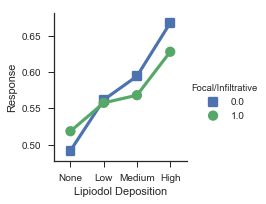

In [705]:
g = sns.factorplot(x="Lipiodol Deposition", y="Response", hue="Focal/Infiltrative", data=df, size=3, ci=None, markers=["s", "o"])#, col_wrap=2
#plt.setp(g.collections[0], sizes=[100], label="x")
#plt.plot(df["Lipiodol Deposition"], df["Response"], linestyle='None', marker="s", color="r", markersize=10)
#grid.map(plt.axhline, y=0, ls=":", c=".5")
#grid.map(plt.plot, , marker="o", ms=4)
#grid.set(xticks=np.arange(5), yticks=[-3, 3], xlim=(-.5, 4.5), ylim=(-3.5, 3.5))
#grid.fig.tight_layout(w_pad=1)

In [697]:
from matplotlib.lines import Line2D

In [698]:
Line2D.markers

{0: 'tickleft',
 1: 'tickright',
 'd': 'thin_diamond',
 3: 'tickdown',
 4: 'caretleft',
 5: 'caretright',
 6: 'caretup',
 7: 'caretdown',
 8: 'caretleftbase',
 9: 'caretrightbase',
 10: 'caretupbase',
 2: 'tickup',
 '<': 'triangle_left',
 '_': 'hline',
 'P': 'plus_filled',
 'x': 'x',
 'h': 'hexagon1',
 '8': 'octagon',
 'p': 'pentagon',
 11: 'caretdownbase',
 '+': 'plus',
 '2': 'tri_up',
 'v': 'triangle_down',
 'H': 'hexagon2',
 '3': 'tri_left',
 '|': 'vline',
 '^': 'triangle_up',
 None: 'nothing',
 '1': 'tri_down',
 '4': 'tri_right',
 '>': 'triangle_right',
 'o': 'circle',
 ',': 'pixel',
 'D': 'diamond',
 '.': 'point',
 's': 'square',
 '*': 'star',
 ' ': 'nothing',
 '': 'nothing',
 'None': 'nothing',
 'X': 'x_filled'}

In [694]:
plt.setp(g.collections[0])

  agg_filter: unknown
  alpha: float or None 
  animated: [True | False] 
  antialiased or antialiaseds: Boolean or sequence of booleans 
  array: unknown
  axes: an :class:`~matplotlib.axes.Axes` instance 
  clim: a length 2 sequence of floats 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  cmap: a colormap or registered colormap name 
  color: matplotlib color arg or sequence of rgba tuples
  contains: a callable function 
  edgecolor or edgecolors: matplotlib color spec or sequence of specs 
  facecolor or facecolors: matplotlib color spec or sequence of specs 
  figure: a :class:`matplotlib.figure.Figure` instance 
  gid: an id string 
  hatch: [ '/' | '\\' | '|' | '-' | '+' | 'x' | 'o' | 'O' | '.' | '*' ] 
  label: string or anything printable with '%s' conversion. 
  linestyle or dashes or linestyles: [

In [ ]:
grid = sns.factorplot(x="Lipiodol Deposition", y="Response", hue="Focal/Infiltrative", data=df, size=3, ci=None)

In [ ]:
def format_plt():
    plt.ylim(.3,1)
    plt.xticks(range(4), ["None", "Low", "Medium", "High"])

([<matplotlib.axis.XTick at 0x2a6138621d0>,
 <a list of 4 Text xticklabel objects>)

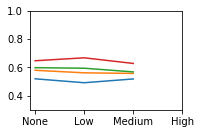

In [542]:
plt.figure(1)
plt.subplot(221)
plt.plot(MEAN, '.')
plt.plot(FOCAL, '.')
plt.plot(INFIL)

plt.ylim(.3,1)
plt.xticks(range(4), ["None", "Low", "Medium", "High"])

In [532]:
print(len(Rdf))
MEAN=Rdf.mean().values

44


In [533]:
#well delineated
print(len(Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 0]))
FOCAL=Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 0].mean().values

26


In [534]:
#infiltrative
print(len(Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 1]))
INFIL=Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 1].mean().values

14


In [535]:
#HCC
print(len(Rdf[master_df.loc[Rdf.index, "HCC(0), ICC(1), other(2)"] == 0]))
HCC=Rdf[master_df.loc[Rdf.index, "HCC(0), ICC(1), other(2)"] == 0].mean().values

26


In [536]:
#ICC
print(len(Rdf[master_df.loc[Rdf.index, "HCC(0), ICC(1), other(2)"] == 1]))
ICC=Rdf[master_df.loc[Rdf.index, "HCC(0), ICC(1), other(2)"] == 1].mean().values

8


In [537]:
#met
print(len(Rdf[master_df.loc[Rdf.index, "HCC(0), ICC(1), other(2)"] == 2]))
MET=Rdf[master_df.loc[Rdf.index, "HCC(0), ICC(1), other(2)"] == 2].mean().values

7


In [538]:
#selective
print(len(Rdf[master_df.loc[Rdf.index, "selective=0"] == 0]))
SEL=Rdf[master_df.loc[Rdf.index, "selective=0"] == 0].mean().values

6


In [539]:
#lobar
print(len(Rdf[master_df.loc[Rdf.index, "selective=0"] == 1]))
LOB=Rdf[master_df.loc[Rdf.index, "selective=0"] == 1].mean().values

7


In [511]:
foc_Rdf = Rdf[master_df.loc[Rdf.index, "0=well delineated, 1=infiltrative"] == 0]

In [513]:
#homog
print(len(foc_Rdf[(pattern_df["lipcoverage_vol%"] > .75)]))
foc_Rdf[pattern_df["lipcoverage_vol%"] > .75].mean().values

10


C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.39449099, 0.4858583 , 0.52203684, 0.65974027])

In [514]:
#focal hetero
print(len(foc_Rdf[(pattern_df["lipcoverage_vol%"] <= .75)]))
foc_Rdf[pattern_df["lipcoverage_vol%"] <= .75].mean().values

16


C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.5524819 , 0.6093798 , 0.63989218, 0.67352547])

In [516]:
print(len(Rdf[pattern_df["lipcoverage_vol%"] < .25]))
Rdf[pattern_df["lipcoverage_vol%"] < .25].mean().values

18


C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.55600647, 0.61611573, 0.61103582, 0.5965519 ])

In [500]:
print(len(Rdf[(pattern_df["lipcoverage_vol%"] >= .25) & (pattern_df["lipcoverage_vol%"] <= .75)]))
Rdf[(pattern_df["lipcoverage_vol%"] >= .25) & (pattern_df["lipcoverage_vol%"] <= .75)].mean().values

16


C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.5565615 , 0.59772221, 0.6316417 , 0.69694304])

In [506]:
print(len(Rdf[(pattern_df["rim_lipiodol%"] > .25) & (pattern_df["lipcoverage_vol%"] <= .75)]))
Rdf[(pattern_df["rim_lipiodol%"] > .25) & (pattern_df["lipcoverage_vol%"] <= .75)].mean().values

9


C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.5611871 , 0.59733044, 0.60364242, 0.66189054])

In [507]:
print(len(Rdf[(pattern_df["rim_lipiodol%"] <= .25) & (pattern_df["lipcoverage_vol%"] <= .75)]))
Rdf[(pattern_df["rim_lipiodol%"] <= .25) & (pattern_df["lipcoverage_vol%"] <= .75)].mean().values

25


C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.55449667, 0.61110658, 0.62688521, 0.63728032])

In [ ]:
print([df[i].mean() for i in liplvls])

[1-df[i].mean() for i in liplvls]

[x/(1-x) for x in [0.47604184262689564,
 0.3884550297888517,
 0.3352322775428981,
 0.2986988994268489]]

In [ ]:
[1-df[i].mean() for i in liplvls]

In [ ]:
print([df[i].mean() for i in liplvls])

print(np.nanmean(depo_resp_df[0]),
np.nanmean(depo_resp_df[100]),
np.nanmean(depo_resp_df[150]),
np.nanmean(depo_resp_df[200]))

### Ground truth patterns

In [87]:
pattern_gtruth_df = pd.read_excel(r"D:\Lipiodol\Results\Lipiodol Patterns.xlsx", index_col=0)

In [88]:
joint_df = pd.concat([vasc_depo_df, pattern_gtruth_df], axis=1, join='inner')

In [89]:
joint_df.columns

Index([                   0,                  100,                  150,
                        200,        'homogeneous',      'heterogeneous',
                      'rim',     'central recess', 'central deposition',
          'penumbra/margin',           'comments'],
      dtype='object')

In [116]:
DF=joint_df.dropna(subset=["heterogeneous"], axis=0)
subset_df = DF.loc[DF["heterogeneous"].str.contains("yes"), liplvls+["heterogeneous"]]
#subset_df = DF.loc[DF["penumbra/margin"]!="no", liplvls+["penumbra/margin"]]
subset_df

,0,100,150,200,heterogeneous
BM-01,0.979969,0.972471,0.989408,0.989211,yes
BM-02,0.213386,0.338595,0.488734,0.349517,yes scattered
BM-03,0.053209,0.034601,0.019784,0.016724,yes
BM-05,0.776399,0.714221,0.620473,0.560444,yes
BM-06,0.484110,0.737965,0.766199,0.769996,yes
BM-07,0.381427,0.579057,0.656548,0.721992,yes
BM-09,0.373079,0.439064,0.683052,0.738784,yes
BM-10,0.674982,0.797312,0.918109,0.938735,yes
BM-12,0.435976,0.563419,0.738764,0.899583,yes
BM-19,0.807288,0.864336,0.747795,0.843143,yes


In [117]:
subset_df.index

Index(['BM-01', 'BM-02', 'BM-03', 'BM-05', 'BM-06', 'BM-07', 'BM-09', 'BM-10',
       'BM-12', 'BM-19', 'BM-23', 'BM-24', 'BM-26', 'BM-27', 'BM-29', 'BM-30',
       'BM-31', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-05', 'PK-07',
       'PK-08'],
      dtype='object')

In [ ]:
rim = 

RIM: "BM-07", "BM-30", "BM-32", "BM-37"
Homogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Heterogeneous: "BM-18", "BM-25", "BM-39", "PK-03", "PK-06"
Central deposition: 'BM-18', 'BM-23', 'BM-25', 'BM-31', 'BM-32', 'BM-39', 'PK-03', 'PK-08'
Central recess: 'BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'
Margin: 'BM-30', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-03', 'PK-05'

In [114]:
len(['BM-01', 'BM-07', 'BM-12', 'BM-19', 'BM-24', 'BM-30', 'BM-36', 'PK-02', 'PK-05'])

9

In [120]:
len(subset_df)

25

In [118]:
subset_df = joint_df.loc[['BM-01', 'BM-02', 'BM-03', 'BM-05', 'BM-06', 'BM-07', 'BM-09', 'BM-10',
       'BM-12', 'BM-19', 'BM-23', 'BM-24', 'BM-26', 'BM-27', 'BM-29', 'BM-30',
       'BM-31', 'BM-32', 'BM-36', 'BM-37', 'BM-39', 'PK-02', 'PK-05', 'PK-07',
       'PK-08'], [0,1,2,3]]
subset_df

,0,100,150,200
BM-01,0.979969,0.972471,0.989408,0.989211
BM-02,0.213386,0.338595,0.488734,0.349517
BM-03,0.053209,0.034601,0.019784,0.016724
BM-05,0.776399,0.714221,0.620473,0.560444
BM-06,0.484110,0.737965,0.766199,0.769996
BM-07,0.381427,0.579057,0.656548,0.721992
BM-09,0.373079,0.439064,0.683052,0.738784
BM-10,0.674982,0.797312,0.918109,0.938735
BM-12,0.435976,0.563419,0.738764,0.899583
BM-19,0.807288,0.864336,0.747795,0.843143


In [119]:
#subset_df.mean().values
subset_df.dropna().mean().values

array([0.49861879, 0.54283119, 0.60239339, 0.64819033])

In [47]:
print(np.mean(subset_df[150]), np.mean(subset_df[200]))

0.4725199969765699 0.7846028172462818


In [514]:
vasc_depo_df.to_excel(writer, "Vascularization-Deposition")
depo_resp_df.to_excel(writer, "Deposition-Response")
writer.save()

In [ ]:
vasc_depo_df

In [515]:
liplvls=[0,100]#,250,300]#list(range(0,401,10))

In [516]:
importlib.reload(lm)
vasc_depo_df_binary = pd.DataFrame(columns=liplvls)
for patient_id in lipresp_df.index:
    vasc_depo_df_binary.loc[patient_id] = lm.vascular_to_deposition(patient_id, target_dir, liplvls, exclude_small=True)

In [517]:
depo_resp_df_binary = pd.DataFrame(columns=liplvls)
for patient_id in lipresp_df.index:
    depo_resp_df_binary.loc[patient_id] = lm.lip_to_response(patient_id, target_dir, liplvls, exclude_small=False)

In [518]:
vasc_depo_df_binary.to_excel(writer, "Vasc-Depo-binary")
depo_resp_df_binary.to_excel(writer, "Depo-Resp-binary")
writer.save()

### T-Test

In [522]:
scipy.stats.ttest_1samp((vasc_depo_df_binary[100]-vasc_depo_df_binary[0]).dropna(), 0)

Ttest_1sampResult(statistic=2.3802691829515616, pvalue=0.025971980984010247)

In [523]:
scipy.stats.ttest_1samp((vasc_depo_df[150]-vasc_depo_df[100]).dropna(), 0)

Ttest_1sampResult(statistic=2.428121152144739, pvalue=0.024249353783670376)

In [524]:
scipy.stats.ttest_1samp((vasc_depo_df[200]-vasc_depo_df[150]).dropna(), 0)

Ttest_1sampResult(statistic=2.7092952234597485, pvalue=0.013907459079104805)

In [525]:
scipy.stats.ttest_1samp((depo_resp_df_binary[100]-depo_resp_df_binary[0]).dropna(), 0)

Ttest_1sampResult(statistic=3.492729013676934, pvalue=0.0015538515664505574)

In [533]:
scipy.stats.ttest_1samp((depo_resp_df[150]-depo_resp_df[100]).dropna(), 0)

Ttest_1sampResult(statistic=1.2250109889424856, pvalue=0.2348033858355313)

In [534]:
scipy.stats.ttest_1samp((depo_resp_df[200]-depo_resp_df[150]).dropna(), 0)

Ttest_1sampResult(statistic=2.800068905160147, pvalue=0.011421953792365588)

## Create Ranked DICOMs

In [412]:
importlib.reload(lm)
lm.write_ranked_imgs(pattern_df, target_dir, "lipcoverage_vol%", "ct24_path", join(C.ranking_dir, "coverage_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")
lm.write_ranked_imgs(pattern_df, target_dir, "enhancing_vol%", "mribl_art_path", join(C.ranking_dir, "coverage_ranking_mrbl"),
                  False, "mribl_tumor_mask_path")

# make pointers instead?
lm.write_ranked_imgs(pattern_df, target_dir, "rim_lipiodol%", "ct24_path", join(C.ranking_dir, "rim_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")
lm.write_ranked_imgs(pattern_df, target_dir, "rim_enhancing%", "mribl_art_path", join(C.ranking_dir, "rim_ranking_mrbl"),
                  False, "mribl_tumor_mask_path")

In [413]:
lm.write_ranked_imgs(pattern_df, target_dir, "peripheral_coverage%", "ct24_path", join(C.ranking_dir, "penumbra_ranking_ct24"),
                  False, "ct24_tumor_mask_path", "ct")

In [141]:
masks.create_dcm_with_masks(ball_ct24_path, [ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path],
                            save_dir, overwrite=True, window="ct")

## Tumor Mask Screenshots

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths

    lm.draw_unreg_fig(mribl_art_path, mribl_tumor_mask_path, join(C.png_dir, patient_id, "BL MR"), 'b', 'mr')
    lm.draw_unreg_fig(mri30d_art_path, mri30d_tumor_mask_path, join(C.png_dir, patient_id, "30d MR"), 'r', 'mr')
    lm.draw_unreg_fig(ct24_path, ct24_tumor_mask_path, join(C.png_dir, patient_id, "24h CT"), 'g', 'ct')

In [ ]:
lm.draw_reg_fig(ball_mribl_path, ball_mribl_enh_mask_path, join(C.fig_dir, patient_id, "MRIBL"), 'b', 'mr')
lm.draw_reg_fig(ball_mri30d_path, ball_mri30d_enh_mask_path, "D:\\Lipiodol\\Figures\\MRI30d", 'r', 'mr')
lm.draw_reg_fig(ball_ct24_path, ball_highlip_mask_path, "D:\\Lipiodol\\Figures\\Lip", 'g', 'ct')

In [ ]:
# Figure for 24h CT
img,_ = hf.nii_load(ball_ct24_path)
blmask,_ = masks.get_mask(ball_mribl_enh_mask_path)
fumask,_ = masks.get_mask(ball_mri30d_enh_mask_path)

for sl in range(img.shape[-1]//4,img.shape[-1]*3//4,img.shape[-1]//12):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    FU=plt.contour(fumask[:,:,sl], colors='r', alpha=.4)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.contourf(fumask[:,:,sl], colors=[(0,0,0,0)]*6+[(1,0,0,.2)]) #look at the length of FU.allsegs
    plt.contourf(blmask[:,:,sl], colors=[(0,0,0,0)]*6+[(0,0,1,.2)])
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\24hCT_%d.png" % sl, dpi=100, bbox_inches='tight')

### DICOMs for HU threshold validation

In [381]:
importlib.reload(masks)
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    lowlip_mask_path = join(mask_dir, "low_lipiodol")

    masks.create_dcm_with_multimask(ct24_path, [highlip_mask_path, midlip_mask_path, lowlip_mask_path],
                                    join(C.fig_dir, "HU threshold validation", patient_id), overwrite=True, padding=0, window="ct")

### Binary masks for sphering figure

In [ ]:
importlib.reload(hf)
liver_dir = join(C.fig_dir, "sphering figure", "liver binary mask")
tumor_dir = join(C.fig_dir, "sphering figure", "tumor binary mask")
if not exists(liver_dir):
    os.makedirs(liver_dir)
if not exists(tumor_dir):
    os.makedirs(tumor_dir)
                
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    if False:
        M = hf.crop_nonzero(masks.get_mask(mribl_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_BLMR.png" % patient_id), dpi=100, bbox_inches='tight')

        M = hf.crop_nonzero(masks.get_mask(ct24_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_24hCT.png" % patient_id), dpi=100, bbox_inches='tight')

        M = hf.crop_nonzero(masks.get_mask(mri30d_liver_mask_path)[0], pad=5)[0]
        plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
        plt.axis('off')
        plt.savefig(join(liver_dir, "%s_30dMR.png" % patient_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mribl_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_BLMR.png" % patient_id), dpi=100, bbox_inches='tight')
                
    M = hf.crop_nonzero(masks.get_mask(ct24_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_24hCT.png" % patient_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_30dMR.png" % patient_id), dpi=100, bbox_inches='tight')

In [ ]:
importlib.reload(hf)
liver_dir = join(C.fig_dir, "sphering figure", "liver with mask")
tumor_dir = join(C.fig_dir, "sphering figure", "tumor with mask")
if not exists(liver_dir):
    os.makedirs(liver_dir)
if not exists(tumor_dir):
    os.makedirs(tumor_dir)
                
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    M = hf.crop_nonzero(masks.get_mask(mribl_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_BLMR.png" % patient_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(ct24_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_24hCT.png" % patient_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_liver_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(liver_dir, "%s_30dMR.png" % patient_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mribl_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_BLMR.png" % patient_id), dpi=100, bbox_inches='tight')
                
    M = hf.crop_nonzero(masks.get_mask(ct24_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_24hCT.png" % patient_id), dpi=100, bbox_inches='tight')

    M = hf.crop_nonzero(masks.get_mask(mri30d_tumor_mask_path)[0], pad=5)[0]
    plt.imshow(M[:,:,M.shape[-1]//2], cmap='gray')
    plt.axis('off')
    plt.savefig(join(tumor_dir, "%s_30dMR.png" % patient_id), dpi=100, bbox_inches='tight')

In [ ]:
M = hf.crop_nonzero(masks.get_mask(ball_mask_path)[0], pad=5)[0]
plt.imshow(M[:,:,M.shape[-1]//2+40], cmap='gray')
plt.axis('off')
plt.savefig("D:\\ball.png", dpi=100, bbox_inches='tight')

## Extra

IVs = get_intensity_section(ball_ct24_path, ball_mask_path, params)
            if highest_I_V < I_V:
                best_params = params
                highest_I_V = I_V
                print(best_params)
theta1_best, phi1_best, dtheta_best, dz_best = best_params

In [ ]:
ball_IV = get_avg_ball_intensity(ball_ct24_path, ball_mask_path)
core_IV = get_avg_core_intensity(ball_ct24_path, ball_mask_path)

In [303]:
ball_IV, core_IV

(197.83461276161094, 209.89937589866474)

In [ ]:
importlib.reload(lm)
IVs = lm.calc_intensity_shells_angles(hf.nii_load(ball_ct24_path)[0], ball_mask_path)
IVs[IVs==0] = np.nan

samples = lm.fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(IVs.shape[-1]):
    print(np.nanmean(IVs[s0,s1,i]))

In [388]:
loopIVs = np.tile(IVs[:-1,:-1,:], (2,2,1))
loopIVs[180:,:,:] = np.nan

In [ ]:
for dtheta in range(30,180,20):
    print(dtheta)
    best_IV = core_IV
    worst_IV = core_IV
    for theta in range(0,180,20):
        for phi in range(180,480,20):
            for shell1 in range(4):
                for shell2 in range(shell1+1,5):
                    IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, shell1:shell2])
                    params = theta, phi % 360, shell1, shell2
                    if best_IV < IV:
                        best_params = params
                        best_IV = IV
                        
            IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, :5])
            params = theta, phi % 360
            if worst_IV > IV:
                worst_params = params
                worst_IV = IV
                
    print(best_params, round(best_IV,1))
    print(worst_params, round(worst_IV,1))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mribl_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mri30d_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
enhmask_density =

In [ ]:
conv_rate = np.zeros((181,360))